In [9]:
import sys
sys.path.append("/cluster/u/rrastogi/ECNN/utils")
import annovar_utils
from evaluation_utils import *

from sklearn.metrics import precision_recall_curve, average_precision_score

import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np

TRAIN_VARIANTS_PATH = "/cluster/u/rrastogi/ECNN/results/d_original/xcap/train_set/filtered_train.tsv"
TEST_VARIANTS_PATH = "/cluster/u/rrastogi/ECNN/results/d_validation/preprocess/remove_train/test.tsv"
TEST_FEATURES_PATH = "/cluster/u/rrastogi/ECNN/results/d_validation/xcap/featurize_0520/total_test.features"

clf = lgb.Booster(model_file="/cluster/u/rrastogi/ECNN/results/d_original/xcap/featurize_0520/clf.mdl")

In [2]:
def get_novel_indices(train_path, test_path):
    train_genes = set()
    for line in open(TRAIN_VARIANTS_PATH):
        row = line.strip().split('\t')
        genes = annovar_utils.get_gene_symbols_from_coding_changes(row[2])
        train_genes |= set(genes)
    
    novel_indxs = []
    for i, line in enumerate(open(TEST_VARIANTS_PATH)):
        row = line.strip().split('\t')
        seen = False
        for g in annovar_utils.get_gene_symbols_from_coding_changes(row[2]):
            if g in train_genes:
                seen = True
        if not seen:
            novel_indxs.append(i)
    return novel_indxs

novel_indxs = get_novel_indices(TRAIN_VARIANTS_PATH, TEST_VARIANTS_PATH)

In [3]:
def plotRoc(hsr=False):
    plt.figure(figsize=(6, 5), dpi=300)
    legend = []

    # All variants
    xcap_labels, xcap_preds = get_xcap_predictions(clf, TEST_FEATURES_PATH)
    xcap_fpr, xcap_tpr, _ = roc_curve(xcap_labels, xcap_preds)
    xcap_auroc = auc(xcap_fpr, xcap_tpr) if not hsr else getHsrAuc(xcap_fpr, xcap_tpr)
    plt.plot(xcap_fpr, xcap_tpr)
    legend.append("X-CAP (all variants): {:.3f}".format(round(xcap_auroc, 3)))

    # Variants on unseen genes
    xcap_labels = xcap_labels[novel_indxs]
    xcap_preds = xcap_preds[novel_indxs]
    xcap_fpr, xcap_tpr, _ = roc_curve(xcap_labels, xcap_preds)
    xcap_auroc = auc(xcap_fpr, xcap_tpr) if not hsr else getHsrAuc(xcap_fpr, xcap_tpr)
    plt.plot(xcap_fpr, xcap_tpr)
    legend.append("X-CAP (variants on previously unseen genes): {:.3f}".format(round(xcap_auroc, 3)))
    
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0] if not hsr else [0.95, 1.0])
    metric = "ROC" if not hsr else "hsr-ROC"
    plt.title("{} ({})".format(metric, "$D_{validation}$"))
    plt.legend(legend, loc="upper left" if hsr else "lower right")
    plt.show()

In [15]:
def plotPrc():
    plt.figure(figsize=(6, 5), dpi=300)
        
    legend = []

    # All variants
    xcap_labels, xcap_predictions = get_xcap_predictions(clf, TEST_FEATURES_PATH)
    xcap_prec, xcap_recall, _ = precision_recall_curve(xcap_labels, xcap_predictions)
    xcap_ap = average_precision_score(xcap_labels, xcap_predictions)
    plt.plot(xcap_recall, xcap_prec)
    legend.append("X-CAP (all variants): {:0.3f}".format(round(xcap_ap, 3)))

    # Variants on unseen genes
    xcap_labels_u = xcap_labels[novel_indxs]
    xcap_predictions_u = xcap_predictions[novel_indxs]
    xcap_prec_u, xcap_recall_u, _ = precision_recall_curve(xcap_labels_u, xcap_predictions_u)
    xcap_ap_u = average_precision_score(xcap_labels_u, xcap_predictions_u)
    plt.plot(xcap_recall_u, xcap_prec_u)
    legend.append("X-CAP (variants on previously unseen genes): {:.3f}".format(xcap_ap_u, 3))
    
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.title("{} ({})".format("PRC", "$D_{validation}$"))
    plt.legend(legend, loc="upper left")
    plt.show()

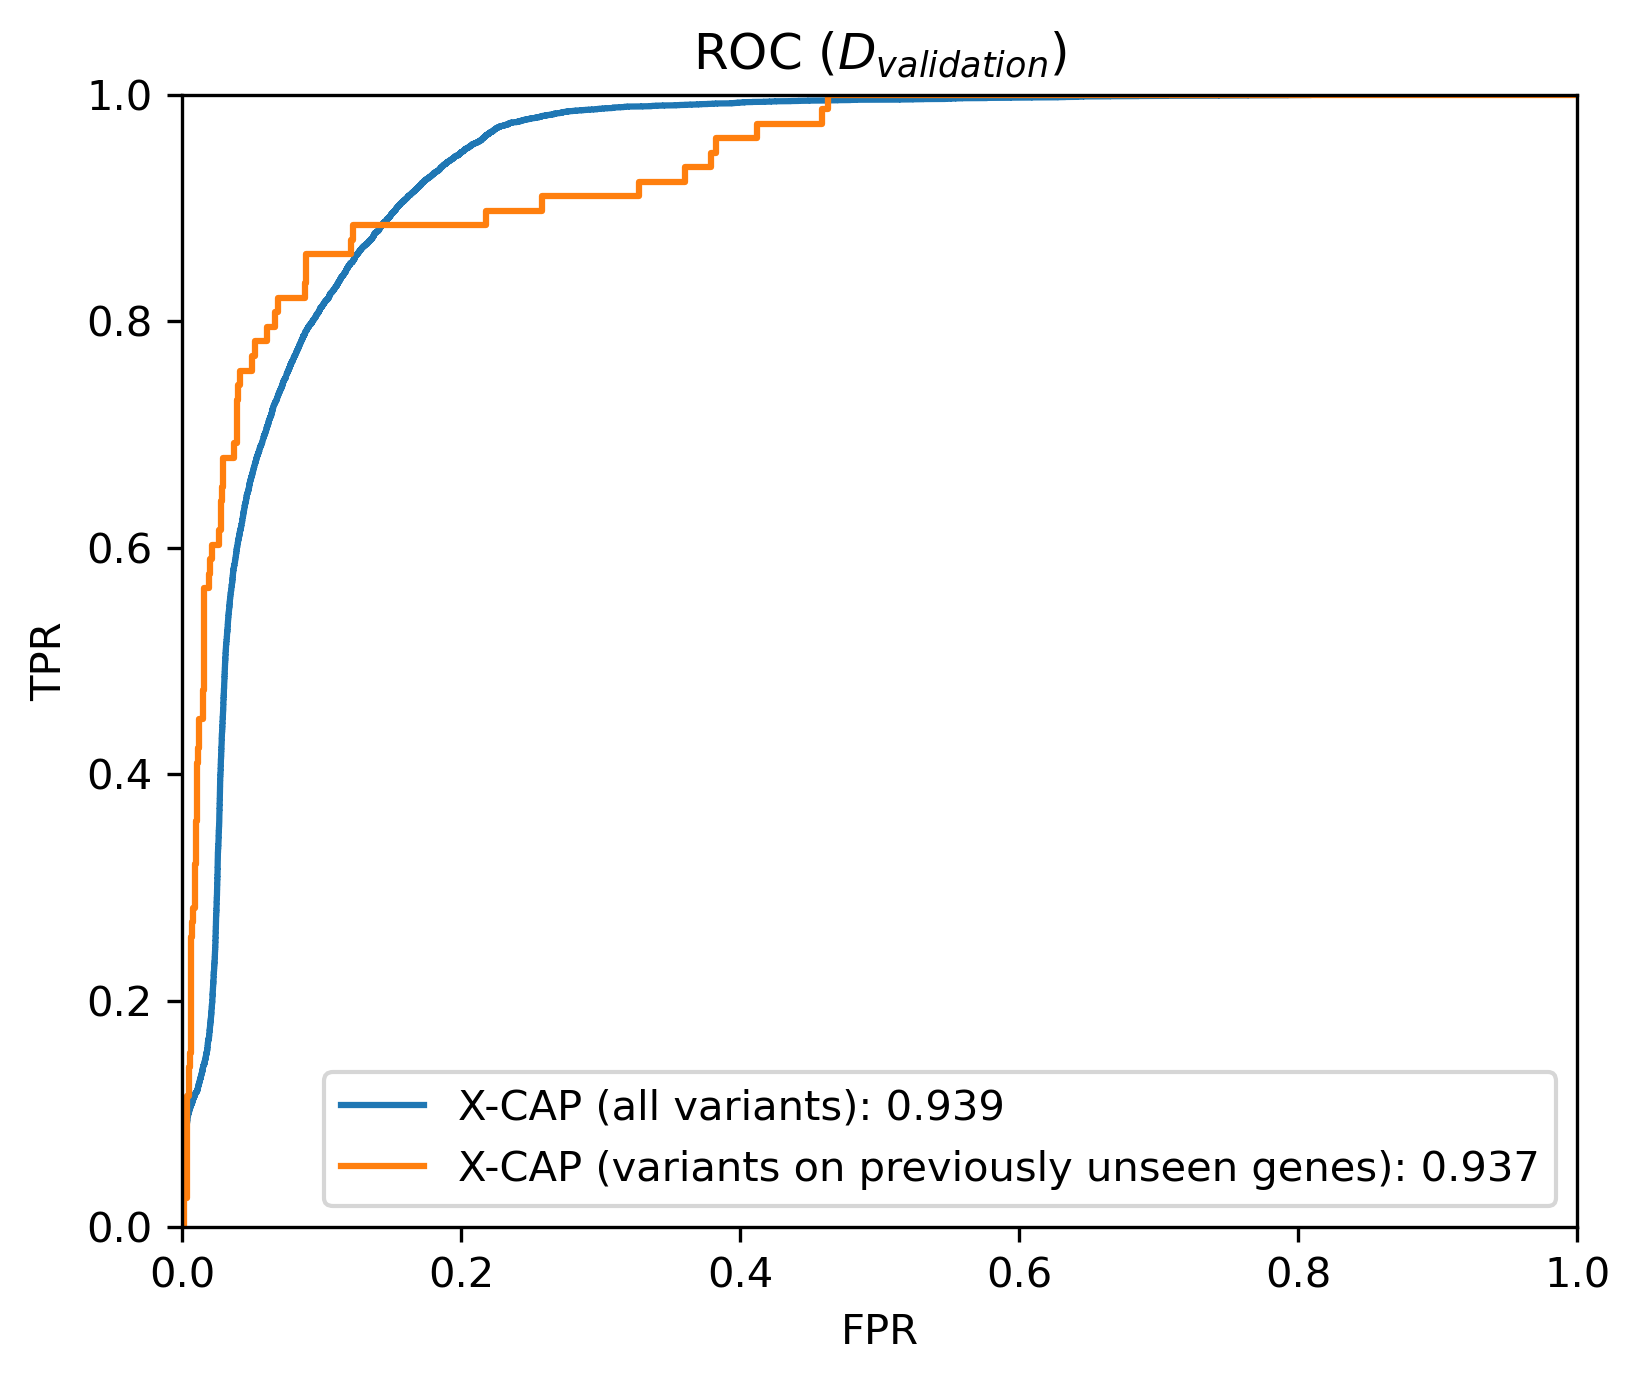

In [4]:
plotRoc()

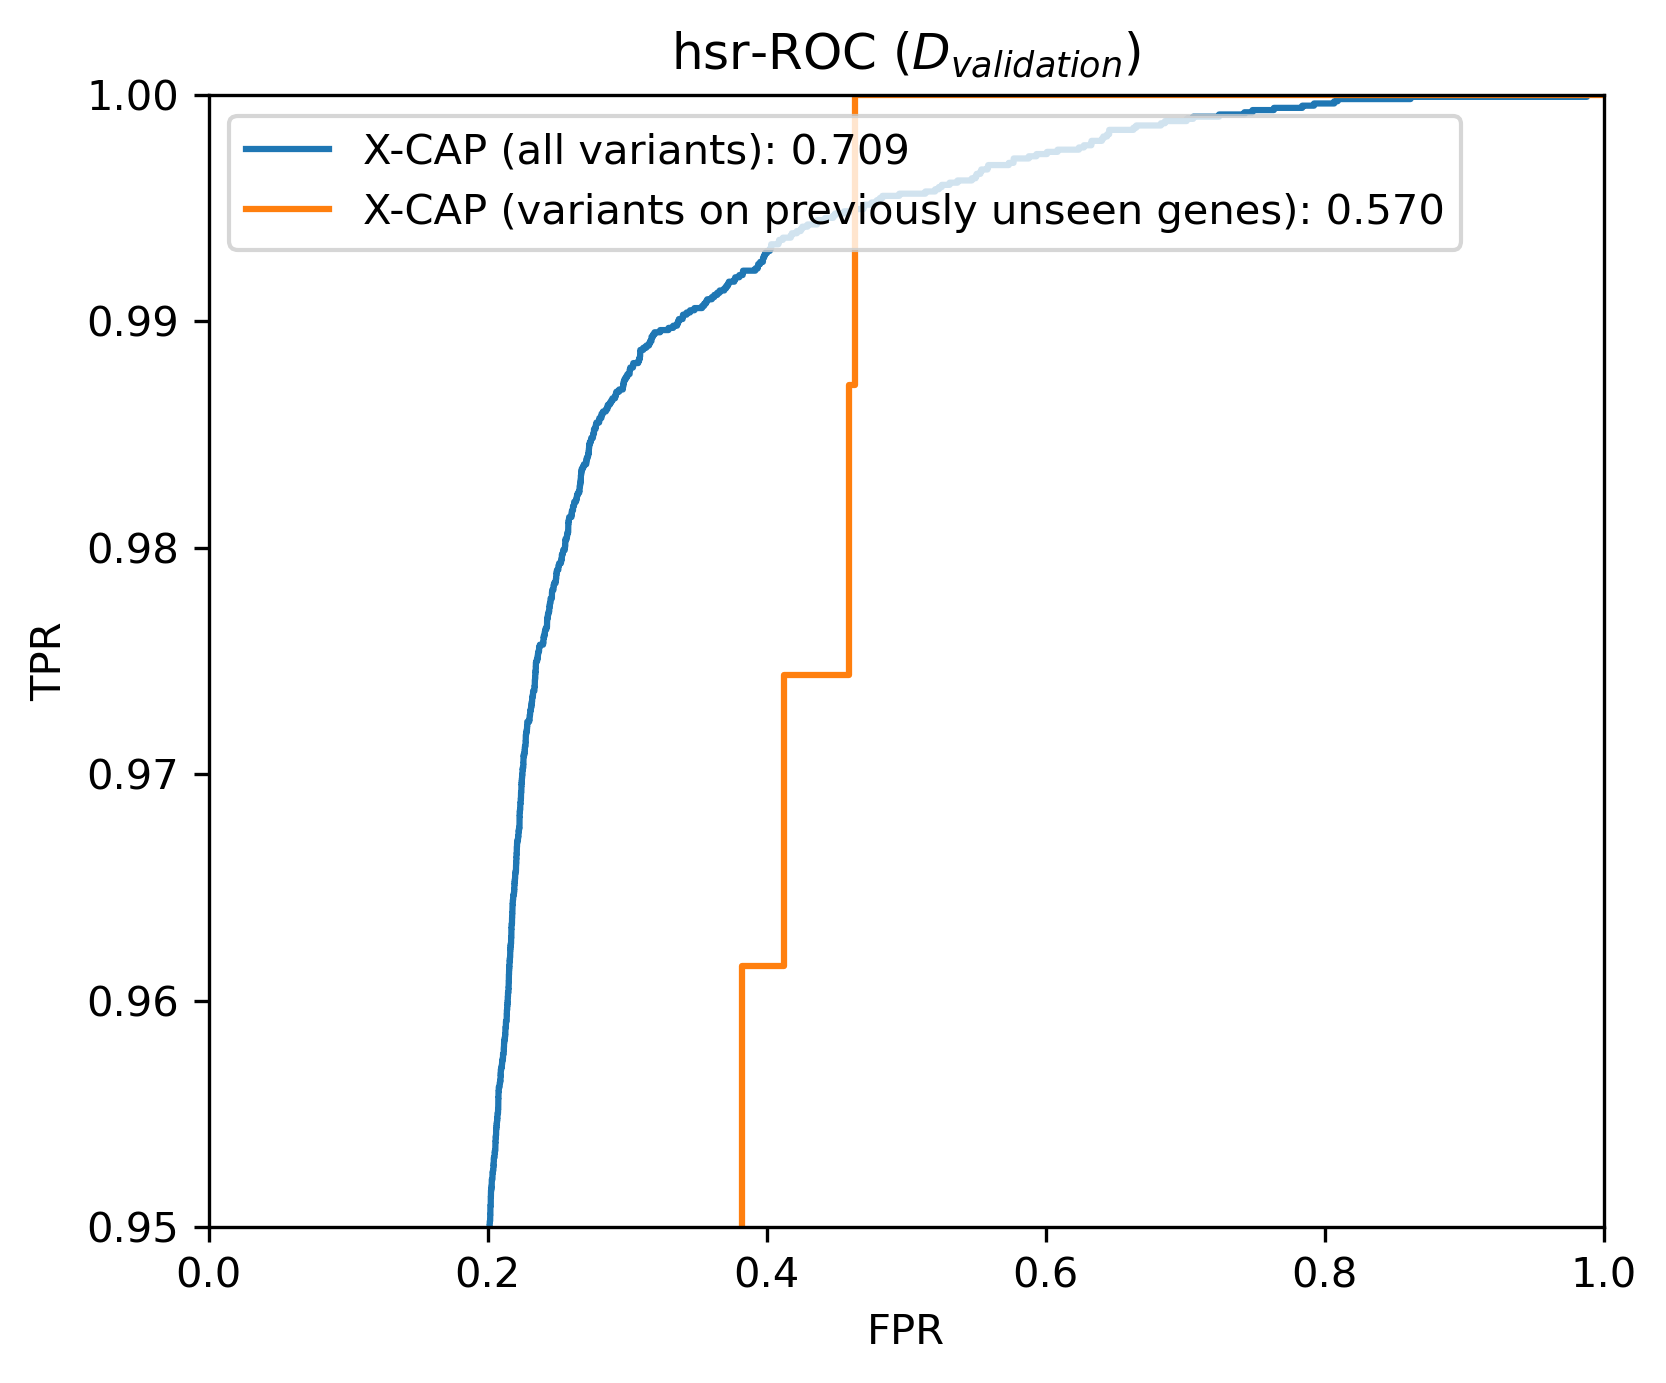

In [5]:
plotRoc(hsr=True)

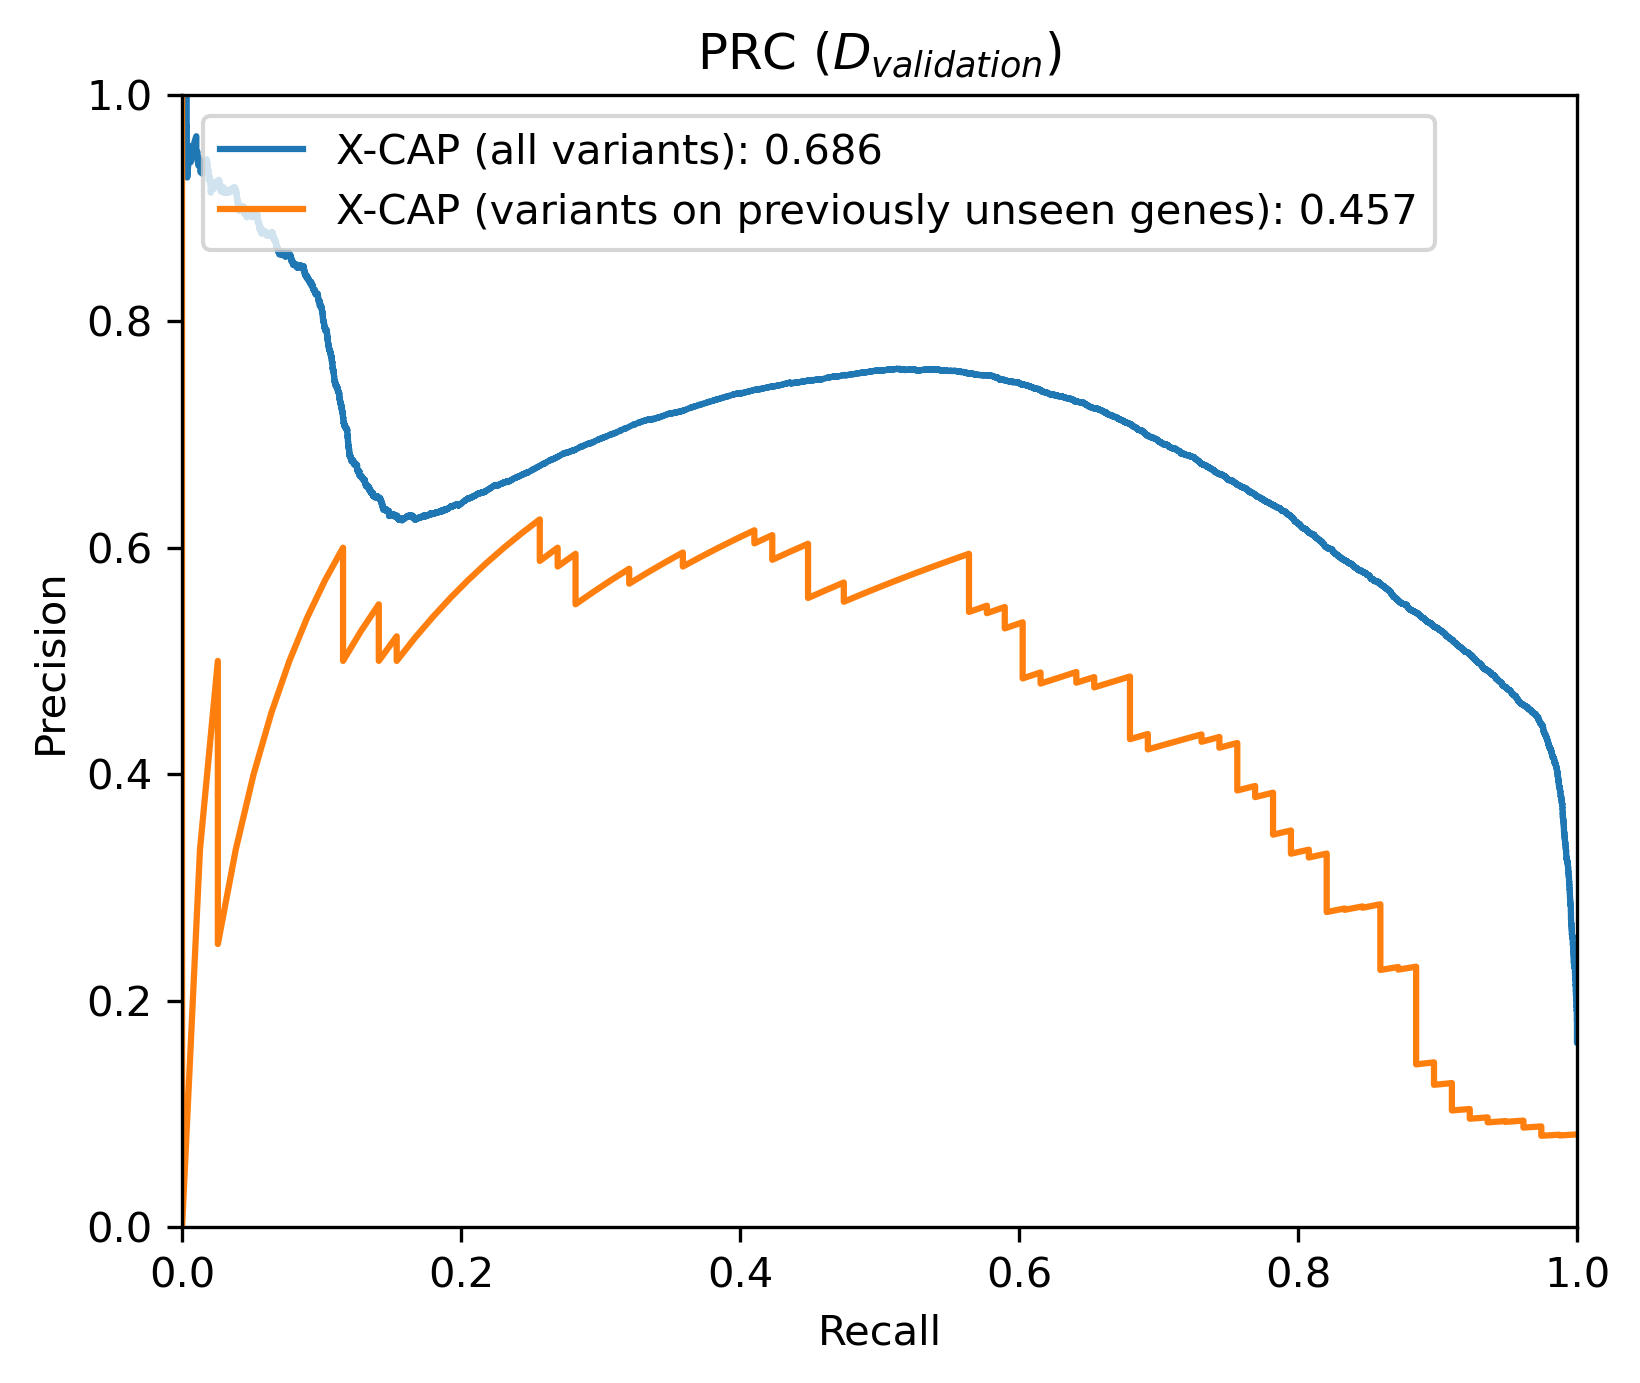

In [16]:
plotPrc()